#Importing the libraries

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
from pmdarima import auto_arima
from scipy.stats import pointbiserialr, spearmanr, kendalltau
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pmdarima as pm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import requests
import copy

#### Getting the url and downloading the dataset in real time

In [ ]:
# CKAN Instance requests are made to toroto's open data portal
main_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Setup main url to extract data related to the dataset
ttc_url = main_url + "/api/3/action/package_show"
parameters = {
    "id": "ttc-bus-delay-data"
}
request_package = requests.get(ttc_url, params = parameters).json()
final_url = ''

# Get resource data from the request package
for idx, resource in enumerate(request_package["result"]["resources"]):

    # Geta active datastores
    if not resource["datastore_active"]:
        url = main_url + "/api/3/action/resource_show?id=" + resource["id"]
        resource_metadata = requests.get(url).json()

        # Get url and select the URL with 2022 data
        url = resource_metadata['result']['url']
        if '2022.xlsx' in url:
            final_url = url
df = pd.read_excel(final_url)
df

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,2022-01-01,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,2022-01-01,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,2022-01-01,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0
...,...,...,...,...,...,...,...,...,...,...
58702,2022-12-31,32,23:21,Saturday,EGLINTON AND EDITH (W,Mechanical,2,24,W,1085
58703,2022-12-31,113,23:28,Saturday,DANFORTH AND DAWES,Vision,20,40,W,8589
58704,2022-12-31,72,23:56,Saturday,LOWER SHERBOURNE AND L,Security,18,36,N,8493
58705,2022-12-31,22,00:17,Saturday,BINGHAM LOOP,Cleaning - Unsanitary,10,20,S,8582


# Data Insights

##### Checking the head and tail of the dataset

In [ ]:
pd.concat([df.head(10), df.tail(10)])

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,0,0,NaN,8531
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,131,161,W,8658
2,2022-01-01,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17,20,S,0
3,2022-01-01,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4,11,S,0
4,2022-01-01,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4,8,S,0
5,2022-01-01,363,02:16,Saturday,KING AND SHAW,Operations - Operator,30,60,NaN,0
6,2022-01-01,96,02:18,Saturday,HUMBERLINE LOOP,Security,0,0,N,3536
7,2022-01-01,320,02:38,Saturday,STEELES AND YONGE,Operations - Operator,4,8,NaN,0
8,2022-01-01,320,02:55,Saturday,YONGE AND STEELES,Operations - Operator,4,8,NaN,0
9,2022-01-01,300,03:18,Saturday,KENNEDY STATION,Emergency Services,0,0,E,8094


##### Data column information  

In [ ]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58707 entries, 0 to 58706
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       58707 non-null  datetime64[ns]
 1   Route      58323 non-null  object        
 2   Time       58707 non-null  object        
 3   Day        58707 non-null  object        
 4   Location   58707 non-null  object        
 5   Incident   58707 non-null  object        
 6   Min Delay  58707 non-null  int64         
 7   Min Gap    58707 non-null  int64         
 8   Direction  48227 non-null  object        
 9   Vehicle    58707 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 4.5+ MB


#### Observing the number of null values

In [ ]:

df.isnull().sum()

Date             0
Route          384
Time             0
Day              0
Location         0
Incident         0
Min Delay        0
Min Gap          0
Direction    10480
Vehicle          0
dtype: int64

#### Statistics of the dataset

In [ ]:
df.describe()

,Min Delay,Min Gap,Vehicle
count,58707.000000,58707.000000,58707.000000
mean,20.115353,32.676154,5467.459298
std,48.945121,50.636856,4356.685772
min,0.000000,0.000000,0.000000
25%,9.000000,17.000000,1553.000000
50%,11.000000,22.000000,7959.000000
75%,20.000000,36.000000,8546.000000
max,999.000000,999.000000,93561.000000


We can see the Min Dalay is more than 999.

# Pre Processing of TTC Dataset

#### Dropping Directions as the direction has no influence on the incident and delays

In [ ]:
df = df.drop("Direction", axis=1)

The direction is not relevant to the our business question.

## Processing Date and Day

In [ ]:
df.rename(columns={"Day":"week_day"},inplace=True)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df["month"] = df["Date"].dt.month
df["day"]= df["Date"].dt.day

Renaming the day to week_day and converting date to month and day

## Processing Routes

In [ ]:
df["Route"].unique()

array([320, 325, 363, 96, 300, 47, 45, 32, 39, 53, 29, 334, 25, 7, 36,
       162, 35, 74, 52, 14, 95, 79, 85, 20, 41, 46, 960, 42, 116, 43, 129,
       54, 89, 11, 102, 70, 124, 24, 88, 935, 127, 37, 60, 17, 34, 72, 91,
       75, 86, 19, 97, 40, 78, 62, 189, 121, 100, 94, 134, 22, 84, 165,
       501, 131, 900, 123, 38, 76, 110, 112, 66, 108, 69, 61, 87, 73, 68,
       63, 26, 71, 504, 161, 57, 21, 105, 130, 118, 67, 44, 90, 106, 56,
       999, 307, 168, 15, 937, 171, 952, 989, 119, 902, 953, 925, 944,
       941, 125, 50, 984, 939, 16, 996, nan, 13, 80, 81, 927, 905, 133,
       160, 107, 109, 111, 98, 122, 924, 48, 995, 600, 23, 51, 99, 65,
       985, 135, 126, 986, 506, 929, 77, 353, 352, 354, 945, 120, 31, 104,
       169, 324, 954, 30, 59, 113, 12, 49, 336, 167, 82, 512, 33, 64, 332,
       339, 101, 83, 396, 343, 384, 115, 92, 8, 335, 545, 9505, 152, 337,
       55, 10, 9, 28, 312, 395, 341, 132, 3, 636, 'A242', 385, 445, 93, 2,
       899, 329, 'OTC', 'RAD', 301, 505, 1, 302

Checking the unique value for Route column

In [ ]:
print("Number of rows with route 927 HIGHWAY 27: ",df[df["Route"]=="927 HIGHWAY 27"].shape[0])
print("Number of rows with route 939 FINCH EXPRESS / 39: ",df[df["Route"]=="939 FINCH EXPRESS / 39"].shape[0])
print("Number of rows with route 600 RAD (LINE 1: ",df[df["Route"]=="600 RAD (LINE 1"].shape[0])
print("Number of rows with route OTC: ",df[df["Route"]=="OTC"].shape[0])
print("Number of rows with route RAD: ",df[df["Route"]=="RAD"].shape[0])

Number of rows with route 927 HIGHWAY 27:  28
Number of rows with route 939 FINCH EXPRESS / 39:  1
Number of rows with route 600 RAD (LINE 1:  1
Number of rows with route OTC:  9
Number of rows with route RAD:  11


In [ ]:
df["Route"] = pd.to_numeric(df["Route"], errors="coerce")
df.dropna(inplace=True)
df["Route"]=df["Route"].astype(int)


Converting the "Route" column to numeric values, dropping rows with NaNs, and finally converting the numeric values to integers.

In [ ]:
df = df.loc[(df['Route'] >= 7) & (df['Route'] <= 996)]

 Filter the DataFrame to retain rows where the "Route" values are between 7 and 996.



In [ ]:
df.describe()

,Route,Min Delay,Min Gap,Vehicle,month,day
count,57424.000000,57424.000000,57424.000000,57424.000000,57424.000000,57424.000000
mean,189.195598,20.045086,32.741136,5491.985476,6.578190,15.831847
std,299.115734,48.212303,49.855372,4348.159301,3.430993,8.740390
min,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,37.000000,9.000000,18.000000,1586.000000,4.000000,8.000000
50%,70.000000,11.000000,22.000000,7965.500000,7.000000,16.000000
75%,116.000000,20.000000,36.000000,8547.000000,9.000000,23.000000
max,996.000000,999.000000,999.000000,93561.000000,12.000000,31.000000


Observing the uniqueness of the routes as TTC in Ontario only has 996 routes. Anything other is not relevant.

## Location and Station Delays

In [ ]:
df["Location"].nunique()

9721

In [ ]:
df["station_delay"]=df['Location'].apply(lambda x: 1 if 'STATION' in str(x) else 0)

Adding new column 'station_delay' by checking condition

In [ ]:
df.describe()

,Route,Min Delay,Min Gap,Vehicle,month,day,station_delay
count,57424.000000,57424.000000,57424.000000,57424.000000,57424.000000,57424.000000,57424.000000
mean,189.195598,20.045086,32.741136,5491.985476,6.578190,15.831847,0.305012
std,299.115734,48.212303,49.855372,4348.159301,3.430993,8.740390,0.460416
min,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,37.000000,9.000000,18.000000,1586.000000,4.000000,8.000000,0.000000
50%,70.000000,11.000000,22.000000,7965.500000,7.000000,16.000000,0.000000
75%,116.000000,20.000000,36.000000,8547.000000,9.000000,23.000000,1.000000
max,996.000000,999.000000,999.000000,93561.000000,12.000000,31.000000,1.000000


Observing the number of stations by encoding them

## Min Delays and Delay Type

##### Removing outliers in Min Delay

In [ ]:
lower_percentile = 0.05
upper_percentile = 0.95

lower_bound = df['Min Delay'].quantile(lower_percentile)
upper_bound = df['Min Delay'].quantile(upper_percentile)

df['Min Delay'] = np.where(df['Min Delay'] < lower_bound, lower_bound, df['Min Delay'])
df['Min Delay'] = np.where(df['Min Delay'] > upper_bound, upper_bound, df['Min Delay'])

Calculating lower and upper bounds based on percentiles and then clips the "Min Delay" values to fall within this range using NumPy's np.where function.

In [ ]:
df = df[df["Min Delay"] >1]

In [ ]:
def delay_type(delay):
  if delay <=10:
    return "short"
  elif delay >10 and delay <=30:
    return "medium"
  else:
    return "long"

In [ ]:
df["delay_type"] = df["Min Delay"].apply(delay_type)

Creating the delay type column by categorizing the delay category as 'short','medium',and 'long'.

Handling outliers by Winsorizing the min delay.

## Rename Columns

In [ ]:
df = df.rename(columns = {'Route':'route','Date':'date', 'Time':'time','Day':'day','Location':'location', 'Incident':'incident',
                                  'Vehicle':'vehicle','Min Delay': 'min_delay', 'Min Gap':'min_gap' })

In [ ]:
pd.concat([df.head(10), df.tail(10)])

,date,route,time,week_day,location,incident,min_delay,min_gap,vehicle,month,day,station_delay,delay_type
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,4.0,0,8531,1,1,0,short
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,36.0,161,8658,1,1,0,long
2,2022-01-01,320,02:00,Saturday,YONGE AND STEELES,Operations - Operator,17.0,20,0,1,1,0,medium
3,2022-01-01,320,02:07,Saturday,YONGE AND STEELES,Operations - Operator,4.0,11,0,1,1,0,short
4,2022-01-01,320,02:13,Saturday,YONGE AND STEELES,Operations - Operator,4.0,8,0,1,1,0,short
5,2022-01-01,363,02:16,Saturday,KING AND SHAW,Operations - Operator,30.0,60,0,1,1,0,medium
6,2022-01-01,96,02:18,Saturday,HUMBERLINE LOOP,Security,4.0,0,3536,1,1,0,short
7,2022-01-01,320,02:38,Saturday,STEELES AND YONGE,Operations - Operator,4.0,8,0,1,1,0,short
8,2022-01-01,320,02:55,Saturday,YONGE AND STEELES,Operations - Operator,4.0,8,0,1,1,0,short
9,2022-01-01,300,03:18,Saturday,KENNEDY STATION,Emergency Services,4.0,0,8094,1,1,1,short


Providing proper names to the columns

In [ ]:
df = df[df["vehicle"] != 0]

In [ ]:
clean_df = copy.deepcopy(df)

# Data Visualisation

#### Histogram Plots

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'route'}>,
        <Axes: title={'center': 'min_delay'}>],
       [<Axes: title={'center': 'min_gap'}>,
        <Axes: title={'center': 'vehicle'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'station_delay'}>, <Axes: >]],
      dtype=object)

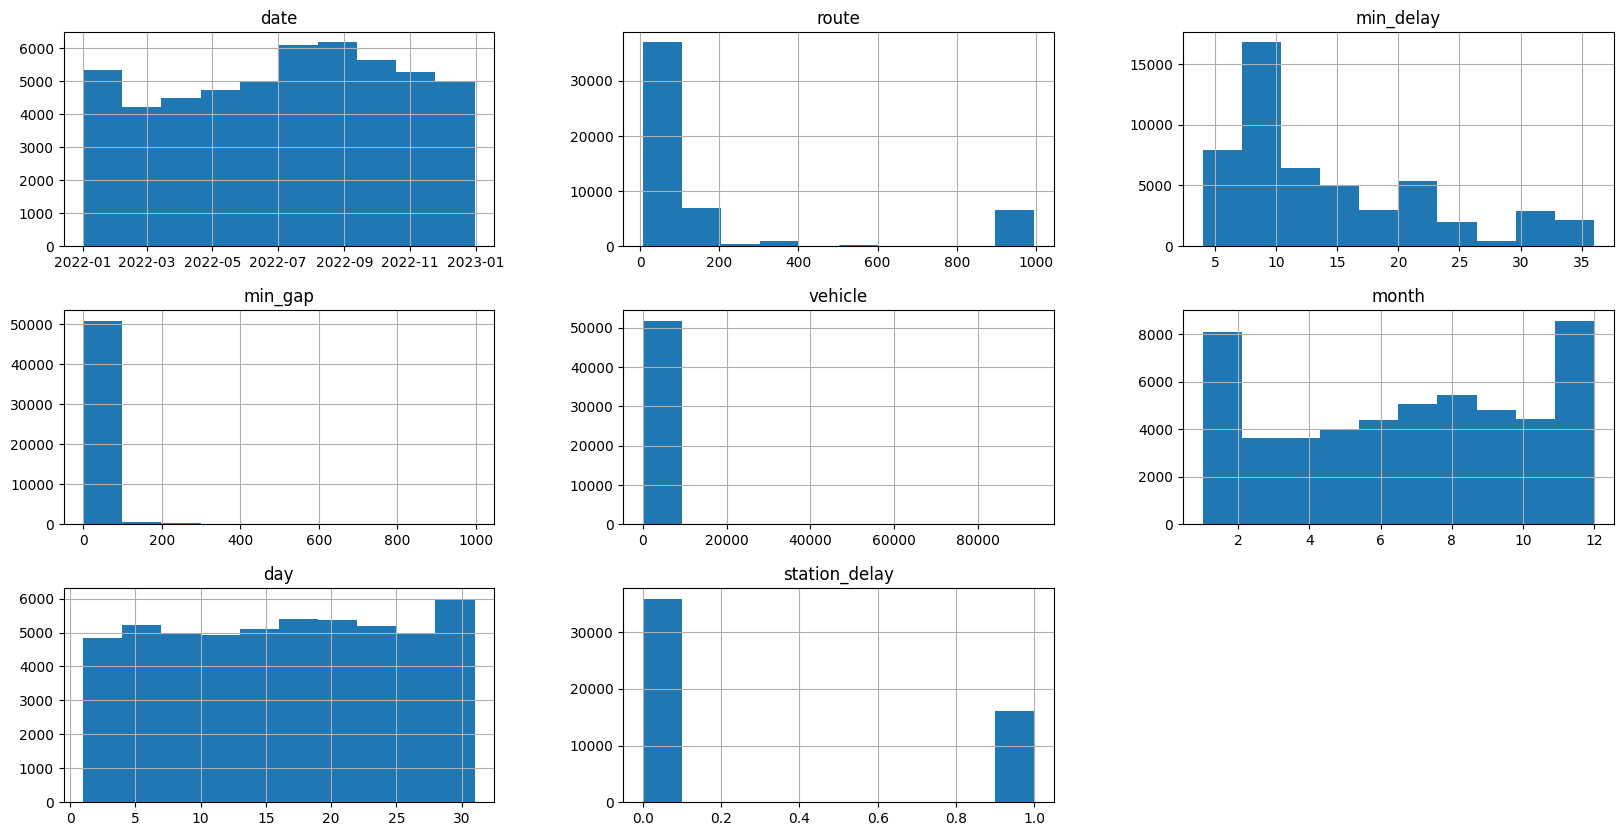

In [ ]:
df.hist(figsize=(20, 10))

Creating the histogram to check the distribution of differnet columns

#### Number of bus date count

<ipython-input-194-178b5a920e5a>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




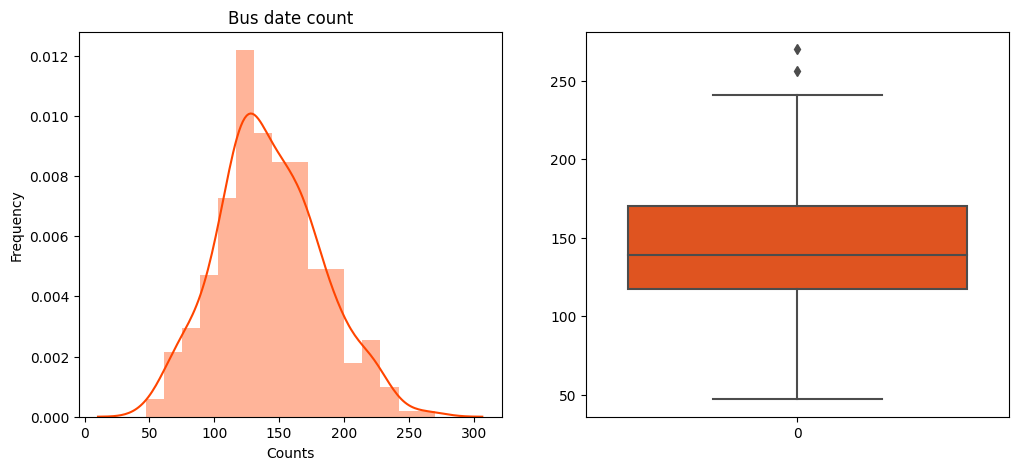

In [ ]:
bus_date_counts = df.date.value_counts()
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.distplot(bus_date_counts, ax=ax[0], color="orangered", kde=True);
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Bus date count");

sns.boxplot(bus_date_counts, ax=ax[1], color="orangered");

#### The time values count and it's frequency

<ipython-input-195-73a22c2a32f7>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




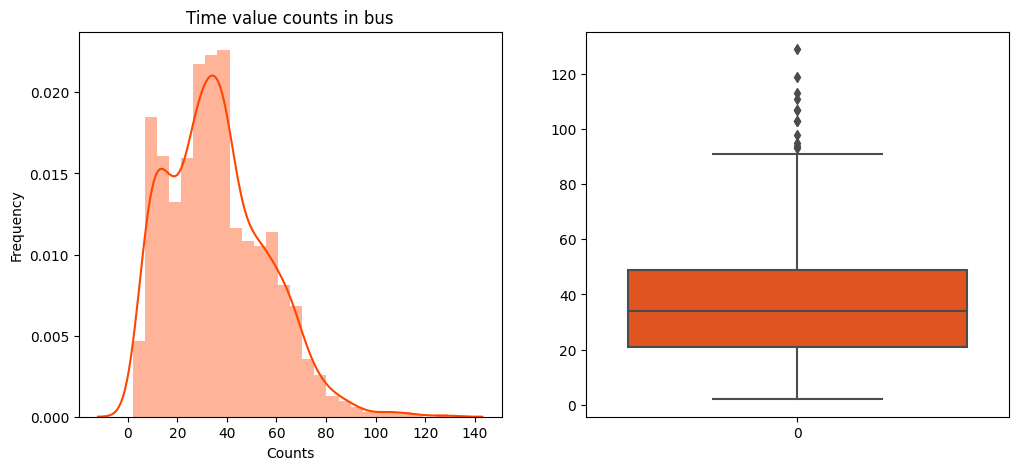

In [ ]:
bus_time_counts = df.time.value_counts()
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.distplot(bus_time_counts, ax=ax[0], color="orangered", kde=True);
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Time value counts in bus");

sns.boxplot(bus_time_counts, ax=ax[1], color="orangered");

#### Average delay time by month in 2022

In [ ]:
df_month = df.groupby(["month"])["min_delay"].mean().reset_index()
fig = px.line(df_month, x="month", y="min_delay", title="Average delay time by month in 2022")
fig.show()

 We can observe that the 2nd (February) followed by 4th (April) and 10th (October) month has the highest number of delays where as, 7th (July) month has the least number of delays.

#### Incident Counts

In [ ]:
incident_counts = df["incident"].value_counts()
fig_bar = go.Figure(data=[go.Bar(x=incident_counts.index, y=incident_counts.values)])
fig_bar.update_layout(title="Incident Counts", xaxis_title="Incident Type", yaxis_title="Count")
fig_bar.show()

We can observe that, the incidents or reason behind the delays are mostly due to Operations-Operator followed by Mechanical Incidents. The Least number of dealys are due the Cleaning -Disinfection and Late Entering Serivce Incidents. We can predict that the cleaning and entering happens when the bus is no longer in service.

#### Incidents by Incident Type

In [ ]:
incidents_by_incident_type = df["incident"].value_counts()
fig_incidents_by_incident_type = go.Figure(data=[go.Pie(
    labels=incidents_by_incident_type.index,
    values=incidents_by_incident_type.values
)])

fig_incidents_by_incident_type.update_layout(title="Incidents by Incident Type", width=1400)
fig_incidents_by_incident_type.show()

We can observe that, the largest portion of the delays i.e. 31 % are due to Operations-Operater and MEchanical Incidents

#### Distribution of Delay Types

In [ ]:
delay_type_count = df['delay_type'].value_counts().reset_index()

fig3 = px.bar(delay_type_count, x='index', y='delay_type', labels={'index': 'Delay Type', 'delay_type': 'Count'},
              title='Distribution of Delay Types')
fig3.show()

We can observe that medium and short delays has the maximum counts, in 2022 while, long delays, are less than 2500.

#### Delay Duration vs Time

In [ ]:
df['hour'] = pd.to_datetime(df['time']).dt.hour
scatter_data = df[df['delay_type'] == 'long']

fig4 = px.scatter(scatter_data, x='hour', y='min_delay', color='incident',
                  labels={'hour': 'Hour', 'min_delay': 'Delay Duration'},
                  title='Delay Duration vs. Time')
fig4.show()

#### Occurance of Min Delay by Month

In [ ]:
grouped_data = df.groupby(['month', 'min_delay','incident']).size().reset_index(name='Count')
fig = px.bar(grouped_data, x='month', y='Count', color='incident',
             labels={'month': 'Month', 'Count': 'Occurrences'},
             title='Occurrences of Min Delay by Month',
             category_orders={'month': list(range(1, 13))},
             width=1200, # To ensure the correct ordering of months
             height=500)

fig.show()

#### Min Delay VS Min Gap

In [ ]:
fig_scatter = go.Figure(data=go.Scatter(x=df["min_delay"], y=df["min_gap"], mode="markers",marker=dict(
        size=10,
        color=df["min_delay"],
        colorbar=dict(title="min_delay")
    )))
fig_scatter.update_layout(title="Min Delay vs. Min Gap", xaxis_title="Min Delay", yaxis_title="Min Gap", )
fig_scatter.show()

We can observe that the number of min delays and min gap are almost the same and are highly correlated.

#### Incident By Day

In [ ]:
day_counts = df["week_day"].value_counts()
fig_day_counts = go.Figure(data=[go.Bar(x=day_counts.index, y=day_counts.values)])
fig_day_counts.update_layout(title="Incidents by Day", xaxis_title="Day", yaxis_title="Count")
fig_day_counts.show()

We can observe that most number of delays are caused in Fridays, followed by Thursday and Wednesday. The least number of delays are on Sundays, as the number of bus services are quiet less and probably TTC bus go through the mechanical services.

# Models

In [ ]:
df = copy.deepcopy(clean_df)

In [ ]:
df

,date,route,time,week_day,location,incident,min_delay,min_gap,vehicle,month,day,station_delay,delay_type
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,4.0,0,8531,1,1,0,short
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,36.0,161,8658,1,1,0,long
6,2022-01-01,96,02:18,Saturday,HUMBERLINE LOOP,Security,4.0,0,3536,1,1,0,short
9,2022-01-01,300,03:18,Saturday,KENNEDY STATION,Emergency Services,4.0,0,8094,1,1,1,short
10,2022-01-01,300,03:32,Saturday,BLOOR AND INDIAN,Security,17.0,34,8452,1,1,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58702,2022-12-31,32,23:21,Saturday,EGLINTON AND EDITH (W,Mechanical,4.0,24,1085,12,31,0,short
58703,2022-12-31,113,23:28,Saturday,DANFORTH AND DAWES,Vision,20.0,40,8589,12,31,0,medium
58704,2022-12-31,72,23:56,Saturday,LOWER SHERBOURNE AND L,Security,18.0,36,8493,12,31,0,medium
58705,2022-12-31,22,00:17,Saturday,BINGHAM LOOP,Cleaning - Unsanitary,10.0,20,8582,12,31,0,short


## ARIMA Time Series Analysis

### Finding p,q,and d values

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df.groupby('date')['min_delay'].mean()
# ts=df["min_delay"]
stepwise_fit = auto_arima(ts, seasonal=False, trace=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2985.493, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2533.186, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1074.116, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1066.465, Time=1.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1067.108, Time=1.00 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1065.385, Time=1.38 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2200.918, Time=0.88 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1067.098, Time=2.91 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1990.550, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1059.261, Time=0.47 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1057.289, T

We can see that the best value for (p,q,d) is (0,0,1)

### ARIMA forecasting

In [ ]:
ts = df.groupby('date')['min_delay'].mean()
# ts=df["min_delay"]
train_size = int(len(ts) * 0.8)
train_data, test_data = ts[:train_size], ts[train_size:]

# model = sm.tsa.arima.ARIMA(train_data, order=(1, 0, 1))
model = pm.auto_arima(train_data, seasonal=False, stepwise=True, suppress_warnings=True, stationary=False)
model_fit = model.fit(train_data)

# Forecasting
forecast_steps = len(test_data)
# forecast = model_fit.forecast(steps=forecast_steps)
forecast = model.predict(n_periods=len(test_data))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Create a Plotly line chart for the forecast
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_data.index, y=test_data, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red')))

fig.update_layout(
    title='Min Delay Forecast using ARIMA',
    xaxis_title='Date',
    yaxis_title='Min Delay',
    width=1200,
    height=500
)

fig.show()

Root Mean Squared Error (RMSE): 1.010354012311245


The ARIMA forecast doesn't seem to work best with the TTC dataset. We tried two methods, fist auto hypertuning the ARIMA p,d,q, values and other, custom auto tuning. The forecasting is done with end 20% of the year, which starts from October 23 to December. The result for both the ways even after changing the hyper parameters is consistent.

## Feature Correlation

In [ ]:
df = copy.deepcopy(clean_df)

##### The time is changed to a specific number of minute from 12:00 am.

In [ ]:
df['time'] = df['time'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df

,date,route,time,week_day,location,incident,min_delay,min_gap,vehicle,month,day,station_delay,delay_type
0,2022-01-01,320,120,Saturday,YONGE AND DUNDAS,General Delay,4.0,0,8531,1,1,0,short
1,2022-01-01,325,120,Saturday,OVERLEA AND THORCLIFFE,Diversion,36.0,161,8658,1,1,0,long
6,2022-01-01,96,138,Saturday,HUMBERLINE LOOP,Security,4.0,0,3536,1,1,0,short
9,2022-01-01,300,198,Saturday,KENNEDY STATION,Emergency Services,4.0,0,8094,1,1,1,short
10,2022-01-01,300,212,Saturday,BLOOR AND INDIAN,Security,17.0,34,8452,1,1,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58702,2022-12-31,32,1401,Saturday,EGLINTON AND EDITH (W,Mechanical,4.0,24,1085,12,31,0,short
58703,2022-12-31,113,1408,Saturday,DANFORTH AND DAWES,Vision,20.0,40,8589,12,31,0,medium
58704,2022-12-31,72,1436,Saturday,LOWER SHERBOURNE AND L,Security,18.0,36,8493,12,31,0,medium
58705,2022-12-31,22,17,Saturday,BINGHAM LOOP,Cleaning - Unsanitary,10.0,20,8582,12,31,0,short


##### Calculating different correlation methods, like, Pearson's, Spearman's rank correlation, Kendall's rank correlation, point-biserial correlation and Cramér's V for numerical-numerical, ordinal-ordinal, ordinal-ordinal, numerical-categorical, and categorical-categorical respectively.

In [ ]:
data = df

le = LabelEncoder()
data['route'] = le.fit_transform(data['route'])
data['week_day'] = le.fit_transform(data['week_day'])
data['location'] = le.fit_transform(data['location'])
data['incident'] = le.fit_transform(data['incident'])
data['delay_type'] = le.fit_transform(data['delay_type'])

# Calculate Pearson's correlation coefficient for numerical-numerical variables
corr_pearson = data.corr(method='pearson')
print('Pearson correlation coefficient:')
fig = px.imshow(corr_pearson)
fig.show()

# Calculate Spearman's rank correlation coefficient for ordinal-ordinal variables
corr_spearman, _ = spearmanr(data[['week_day', 'location', 'incident', 'min_delay', 'min_gap', 'vehicle', 'month', 'day', 'station_delay', 'delay_type']])
print('Spearman rank correlation coefficient:')
print(corr_spearman)
fig = px.imshow(corr_spearman)
fig.show()

# Calculate Kendall's rank correlation coefficient for ordinal-ordinal variables
var_pairs = [('route', 'time'), ('route', 'week_day'), ('route', 'location'), ('route', 'incident'), ('route', 'min_delay'), ('route', 'min_gap'), ('route', 'vehicle'), ('route', 'month'), ('route', 'day'), ('route', 'station_delay'), ('route', 'delay_type')]

# Calculate Kendall's rank correlation coefficient for each pair of variables
for var1, var2 in var_pairs:
    corr_kendall, _ = kendalltau(data[var1], data[var2])
    print(f'Kendall rank correlation coefficient between {var1} and {var2}: {corr_kendall}')

# Calculate point-biserial correlation for numerical-categorical variables
pb_corr1, _ = pointbiserialr(data['min_delay'], data['route'])
pb_corr2, _ = pointbiserialr(data['min_delay'], data['week_day'])
pb_corr3, _ = pointbiserialr(data['min_delay'], data['location'])
pb_corr4, _ = pointbiserialr(data['min_delay'], data['incident'])
pb_corr5, _ = pointbiserialr(data['time'], data['delay_type'])
print('Point-biserial correlation between min_delay and route:', pb_corr1)
print('Point-biserial correlation between min_delay and week_day:', pb_corr2)
print('Point-biserial correlation between min_delay and location:', pb_corr3)
print('Point-biserial correlation between min_delay and incident:', pb_corr4)
print('Point-biserial correlation between time and delay_type:', pb_corr5)

# Calculate Cramér's V for categorical-categorical variables
contingency1 = pd.crosstab(data['delay_type'], data['week_day'])
contingency2 = pd.crosstab(data['delay_type'], data['location'])
contingency3 = pd.crosstab(data['delay_type'], data['incident'])
contingency4 = pd.crosstab(data['delay_type'], data['vehicle'])
chi21, _, _, _ = chi2_contingency(contingency1)
chi22, _, _, _ = chi2_contingency(contingency2)
chi23, _, _, _ = chi2_contingency(contingency3)
chi24, _, _, _ = chi2_contingency(contingency4)
cramers_v1 = np.sqrt(chi21 / (data.shape[0] * (min(contingency1.shape) - 1)))
cramers_v2 = np.sqrt(chi22 / (data.shape[0] * (min(contingency2.shape) - 1)))
cramers_v3 = np.sqrt(chi23 / (data.shape[0] * (min(contingency3.shape) - 1)))
cramers_v4 = np.sqrt(chi24 / (data.shape[0] * (min(contingency4.shape) - 1)))
print("Cramér's V between delay_type and week_day:", cramers_v1)
print("Cramér's V between delay_type and location:", cramers_v2)
print("Cramér's V between delay_type and incident:", cramers_v3)
print("Cramér's V between delay_type and vehicle:", cramers_v4)


Pearson correlation coefficient:


<ipython-input-210-4dfcc3a009d9>:11: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Spearman rank correlation coefficient:
[[ 1.          0.00198099 -0.00568498 -0.00155554 -0.00428183  0.00999255
  -0.00901464 -0.00486147  0.0110537  -0.00532145]
 [ 0.00198099  1.          0.02606104  0.03951771  0.03831385 -0.04265757
  -0.01211506 -0.00570069  0.03486383 -0.04517105]
 [-0.00568498  0.02606104  1.         -0.0548079  -0.04885278  0.03364035
  -0.01204522 -0.00277275  0.14839579  0.06386456]
 [-0.00155554  0.03951771 -0.0548079   1.          0.96247279 -0.04481043
  -0.00110672  0.00808297 -0.00129972 -0.88699685]
 [-0.00428183  0.03831385 -0.04885278  0.96247279  1.         -0.04495781
  -0.00210237  0.00985218  0.00101865 -0.85473461]
 [ 0.00999255 -0.04265757  0.03364035 -0.04481043 -0.04495781  1.
  -0.02559505  0.00674661  0.08455455  0.06728602]
 [-0.00901464 -0.01211506 -0.01204522 -0.00110672 -0.00210237 -0.02559505
   1.          0.00788928 -0.0344668   0.00321667]
 [-0.00486147 -0.00570069 -0.00277275  0.00808297  0.00985218  0.00674661
   0.00788928  1.   

Kendall rank correlation coefficient between route and time: -0.041633270014768506
Kendall rank correlation coefficient between route and week_day: 0.005948886772772407
Kendall rank correlation coefficient between route and location: 0.16684050619898078
Kendall rank correlation coefficient between route and incident: -0.004070946188138104
Kendall rank correlation coefficient between route and min_delay: 0.014097776356958611
Kendall rank correlation coefficient between route and min_gap: 0.010887218513441713
Kendall rank correlation coefficient between route and vehicle: -0.045994710926225105
Kendall rank correlation coefficient between route and month: 0.007594543446066118
Kendall rank correlation coefficient between route and day: -0.000166761003529126
Kendall rank correlation coefficient between route and station_delay: -0.035214012078468956
Kendall rank correlation coefficient between route and delay_type: -0.03382551445484637
Point-biserial correlation between min_delay and route: 

## Regression Models

In [ ]:
X = df.drop(columns=['min_delay','min_gap','station_delay','date'])
y = df['min_delay']

categorical_cols = ['week_day', 'location', 'incident', 'delay_type','route',]
numeric_cols = [ 'time', 'month', 'day']

label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,route,time,week_day,location,incident,vehicle,month,day,delay_type
1307,81,1149,4,8061,10,8156,1,6,2
41777,205,787,6,6070,13,8822,9,14,1
12313,24,1302,2,2668,10,1402,3,19,1
54376,85,1324,0,1420,13,8601,12,2,1
39949,37,785,2,4446,10,1101,9,3,2
...,...,...,...,...,...,...,...,...,...
13445,16,559,5,6983,3,8470,3,29,1
50879,0,845,6,756,1,8391,11,9,2
43822,30,503,1,2816,9,3490,9,26,1
1187,87,793,4,1413,10,8902,1,6,1


### Model Initialization, Fitting, and Prediction

In [ ]:
# Initialize the models
svr_model = SVR()
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()

# Fit the models
svr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
svr_pred = svr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Calculate metrics
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_r2 = r2_score(y_test, svr_pred)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

### Plotting metrics of Regression before Optimization

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['SVR', 'Random Forest', 'Gradient Boosting'],
    'Mean Squared Error': [svr_mse, rf_mse, gb_mse],
    'Mean Absolute Error': [svr_mae, rf_mae, gb_mae],
    'R-squared': [svr_r2, rf_r2, gb_r2]
})

mse_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['Mean Squared Error'], y=[svr_mse]),
    go.Bar(name='Random Forest', x=['Mean Squared Error'], y=[rf_mse]),
    go.Bar(name='Gradient Boosting', x=['Mean Squared Error'], y=[gb_mse])
])
mse_bar.update_layout(title='Mean Squared Error Comparison')

mae_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['Mean Absolute Error'], y=[svr_mae]),
    go.Bar(name='Random Forest', x=['Mean Absolute Error'], y=[rf_mae]),
    go.Bar(name='Gradient Boosting', x=['Mean Absolute Error'], y=[gb_mae])
])
mae_bar.update_layout(title='Mean Absolute Error Comparison')

r2_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['R-squared'], y=[svr_r2]),
    go.Bar(name='Random Forest', x=['R-squared'], y=[rf_r2]),
    go.Bar(name='Gradient Boosting', x=['R-squared'], y=[gb_r2])
])
r2_bar.update_layout(title='R-squared Comparison')

mse_bar.show()
mae_bar.show()
r2_bar.show()

metrics_df

,Model,Mean Squared Error,Mean Absolute Error,R-squared
0,SVR,72.257062,5.984256,-0.109621
1,Random Forest,9.181014,1.964372,0.859011
2,Gradient Boosting,13.923579,2.732987,0.786182


The Random Forest model has the best performance, with the lowest MSE and MAE, and the highest R-squared value. The Gradient Boosting model has the second-best performance, while the SVR model has the worst performance.

### Optimization For Regression

#### Support Vector Machine Optimization

In [ ]:


# # Define parameter grid for SVR
# param_grid_svr = {
#     'kernel': ['linear', 'rbf'],
#     'C': [0.001, 0.01,0.1],
#     'epsilon': [0.01, 0.1, 0.2]
# }

# # Perform grid search
# grid_svr = GridSearchCV(SVR(), param_grid=param_grid_svr, cv=3, scoring='neg_mean_squared_error')
# grid_svr.fit(X_train, y_train)

# # Get the best SVR model
# best_svr = grid_svr.best_estimator_
# best_svr

#### Random Forest Regressor Optimization

In [ ]:
# param_dist_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Perform randomized search
# random_search_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist_rf,
#                                        cv=3, scoring='neg_mean_squared_error')
# random_search_rf.fit(X_train, y_train)

# # Get the best Random Forest model
# best_rf = random_search_rf.best_estimator_
# best_rf

#### Gradient Boosting Regressor Optimization

In [ ]:
# param_grid_gb = {
#     'learning_rate': [0.01, 0.1,1],
#     'n_estimators': [200, 300,400],
#     'max_depth': [4, 5,6],
#     'subsample': [0.8, 0.9, 1.0]
# }

# # Perform grid search
# grid_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_grid_gb,
#                        cv=3, scoring='neg_mean_squared_error')
# grid_gb.fit(X_train, y_train)

# # Get the best Gradient Boosting model
# best_gb = grid_gb.best_estimator_
# best_gb

### Using the optimized hyper parameter tuning

In [ ]:
# Initialize the models
# svr_model = SVR()
rf_model = RandomForestRegressor(min_samples_leaf=2, n_estimators=200)
gb_model = GradientBoostingRegressor(max_depth=6, n_estimators=400)

# Fit the models
# svr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Make predictions
# svr_pred = svr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Calculate metrics
# svr_mse = mean_squared_error(y_test, svr_pred)
# svr_mae = mean_absolute_error(y_test, svr_pred)
# svr_r2 = r2_score(y_test, svr_pred)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

gb_mse = mean_squared_error(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

In [ ]:
metrics_df = pd.DataFrame({
    'Model': ['SVR', 'Random Forest', 'Gradient Boosting'],
    'Mean Squared Error': [svr_mse, rf_mse, gb_mse], #
    'Mean Absolute Error': [ svr_mae,rf_mae, gb_mae], #
    'R-squared': [svr_r2, rf_r2, gb_r2] #
})

mse_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['Mean Squared Error'], y=[svr_mse]),
    go.Bar(name='Random Forest', x=['Mean Squared Error'], y=[rf_mse]),
    go.Bar(name='Gradient Boosting', x=['Mean Squared Error'], y=[gb_mse])
])
mse_bar.update_layout(title='Mean Squared Error Comparison')

# Create bar chart for Mean Absolute Error
mae_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['Mean Absolute Error'], y=[svr_mae]),
    go.Bar(name='Random Forest', x=['Mean Absolute Error'], y=[rf_mae]),
    go.Bar(name='Gradient Boosting', x=['Mean Absolute Error'], y=[gb_mae])
])
mae_bar.update_layout(title='Mean Absolute Error Comparison')

# Create bar chart for R-squared
r2_bar = go.Figure(data=[
    go.Bar(name='SVR', x=['R-squared'], y=[svr_r2]),
    go.Bar(name='Random Forest', x=['R-squared'], y=[rf_r2]),
    go.Bar(name='Gradient Boosting', x=['R-squared'], y=[gb_r2])
])
r2_bar.update_layout(title='R-squared Comparison')

mse_bar.show()
mae_bar.show()
r2_bar.show()

metrics_df

,Model,Mean Squared Error,Mean Absolute Error,R-squared
0,SVR,72.257062,5.984256,-0.109621
1,Random Forest,9.114299,1.956466,0.860036
2,Gradient Boosting,10.111141,2.203952,0.844727


The Random Forest model has the best performance, with the lowest MSE and MAE, and the highest R-squared value. The Gradient Boosting model has the second-best performance, while the SVR model has the worst performance.

### **Comparision**

From the regression before and after hyperparameter tuning, it is observed that,


*   The Random Forest model has a lower Mean Squared Error and a lower Mean Absolute Error after hyper parameter is tuned compared to the model before tuning. The R-squared value is also higher after tuning.
*   The Gradient Boosting model has a slightly lower Mean Squared Error and a lower Mean Absolute Error after tuning. The R-squared value is also slightly higher after tuning.

After tuning, The Random Forest model has the best performance, as it has the lowest Mean Squared Error and the highest R-squared value among all three models.


## Classification Models

In [ ]:
df = copy.deepcopy(clean_df)
df

,date,route,time,week_day,location,incident,min_delay,min_gap,vehicle,month,day,station_delay,delay_type
0,2022-01-01,320,02:00,Saturday,YONGE AND DUNDAS,General Delay,4.0,0,8531,1,1,0,short
1,2022-01-01,325,02:00,Saturday,OVERLEA AND THORCLIFFE,Diversion,36.0,161,8658,1,1,0,long
6,2022-01-01,96,02:18,Saturday,HUMBERLINE LOOP,Security,4.0,0,3536,1,1,0,short
9,2022-01-01,300,03:18,Saturday,KENNEDY STATION,Emergency Services,4.0,0,8094,1,1,1,short
10,2022-01-01,300,03:32,Saturday,BLOOR AND INDIAN,Security,17.0,34,8452,1,1,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58702,2022-12-31,32,23:21,Saturday,EGLINTON AND EDITH (W,Mechanical,4.0,24,1085,12,31,0,short
58703,2022-12-31,113,23:28,Saturday,DANFORTH AND DAWES,Vision,20.0,40,8589,12,31,0,medium
58704,2022-12-31,72,23:56,Saturday,LOWER SHERBOURNE AND L,Security,18.0,36,8493,12,31,0,medium
58705,2022-12-31,22,00:17,Saturday,BINGHAM LOOP,Cleaning - Unsanitary,10.0,20,8582,12,31,0,short


In [ ]:
X = df.drop(columns=['delay_type','date','min_gap','min_delay','station_delay'])
y = df['delay_type']
X['time'] = pd.to_datetime(X['time']).dt.hour * 60 + pd.to_datetime(X['time']).dt.minute
categorical_cols = ['week_day', 'location', 'incident','route']

label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,route,time,week_day,location,incident,vehicle,month,day
1307,81,1149,4,8061,10,8156,1,6
41777,205,787,6,6070,13,8822,9,14
12313,24,1302,2,2668,10,1402,3,19
54376,85,1324,0,1420,13,8601,12,2
39949,37,785,2,4446,10,1101,9,3
...,...,...,...,...,...,...,...,...
13445,16,559,5,6983,3,8470,3,29
50879,0,845,6,756,1,8391,11,9
43822,30,503,1,2816,9,3490,9,26
1187,87,793,4,1413,10,8902,1,6


### Model Initialization, Fitting, and Prediction

In [ ]:
# Initialize and train the models
gb_classifier = GradientBoostingClassifier()
svm_classifier = SVC()
dt_classifier = DecisionTreeClassifier()

gb_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_classifier.predict(X_test)
svm_predictions = svm_classifier.predict(X_test)
dt_predictions = dt_classifier.predict(X_test)

In [ ]:


def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall

# Calculate metrics for each classifier
dt_accuracy, dt_precision, dt_recall = calculate_metrics(y_test, dt_predictions)
svm_accuracy, svm_precision, svm_recall = calculate_metrics(y_test, svm_predictions)
gb_accuracy, gb_precision, gb_recall = calculate_metrics(y_test, gb_predictions)

# Print the metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy:.2f}, Precision: {dt_precision:.2f}, Recall: {dt_recall:.2f}")

print("Support Vector Machine Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}, Precision: {svm_precision:.2f}, Recall: {svm_recall:.2f}")

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gb_accuracy:.2f}, Precision: {gb_precision:.2f}, Recall: {gb_recall:.2f}")

# Create a bar plot using Plotly
import plotly.graph_objects as go

models = ['Decision Tree', 'Support Vector Machine', 'Gradient Boosting']
metrics = ['Accuracy', 'Precision', 'Recall']
values = [[dt_accuracy, svm_accuracy, gb_accuracy],
          [dt_precision, svm_precision, gb_precision],
          [dt_recall, svm_recall, gb_recall]]

fig = go.Figure(data=[
    go.Bar(name=metrics[i], x=models, y=values[i])
    for i in range(len(metrics))
])

# Change the bar mode to stack for grouped bar plot
fig.update_layout(barmode='group', title='Classifier Metrics')
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Decision Tree Metrics:
Accuracy: 0.73, Precision: 0.73, Recall: 0.73
Support Vector Machine Metrics:
Accuracy: 0.53, Precision: 0.51, Recall: 0.53
Gradient Boosting Metrics:
Accuracy: 0.75, Precision: 0.75, Recall: 0.75


The following observation can be made with the metrics of different classifier model used,


* Decision Tree Metrics: The decision tree model has an accuracy of 0.73, which means that it correctly classified 73% of the instances in the test set. The precision and recall are also both 0.73, indicating that the model is equally good at identifying positive and negative instances.

* Support Vector Machine Metrics: The support vector machine model has an accuracy of 0.53, which means that it correctly classified 53% of the instances in the test set. The precision is 0.51, indicating that the model is slightly better at identifying negative instances than positive ones. The recall is 0.53, indicating that the model is equally good at identifying positive and negative instances.

* Gradient Boosting Metrics: The gradient boosting model has an accuracy of 0.75, which means that it correctly classified 75% of the instances in the test set. The precision and recall are also both 0.75, indicating that the model is equally good at identifying positive and negative instances.

The gradient boosting model performed the best, followed by the decision tree model, and then the support vector machine model.

In [ ]:

# Hyperparameter tuning using GridSearchCV (example)
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'degree': [2, 3, 4]
# }

# svm_grid = GridSearchCV(SVC(), param_grid, cv=5)
# svm_grid.fit(X_train, y_train)
# best_svm = svm_grid.best_estimator_

# print("Best SVM parameters:", svm_grid.best_params_)

In [ ]:
# dt_param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, 30,40,50,60],
#     'min_samples_split': [2, 5, 10,20,30,40,50],
#     'min_samples_leaf': [1, 2, 4,6,8,10]
# }

# dt_grid = RandomizedSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=2, verbose=True)
# dt_grid.fit(X_train, y_train)
# best_dt = dt_grid.best_estimator_

# print("Best Decision Tree parameters:", dt_grid.best_params_)

In [ ]:
# gb_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2,0.3],
#     'max_depth': [3, 4, 5,6],
#     'subsample': [0.8, 0.9, 1.0],
# }

# gb_grid = RandomizedSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=2, verbose=True)
# gb_grid.fit(X_train, y_train)
# best_gb = gb_grid.best_estimator_

# print("Best Gradient Boosting parameters:", gb_grid.best_params_)

### After Hyperparameter tuning

In [ ]:
# Initialize and train the models
gb_classifier = GradientBoostingClassifier(subsample= 0.9, n_estimators= 100, max_depth= 6, learning_rate= 0.1)
# svm_classifier = SVC()
dt_classifier = DecisionTreeClassifier(min_samples_split= 50, min_samples_leaf= 6, max_depth= 30, criterion= 'gini')

gb_classifier.fit(X_train, y_train)
# svm_classifier.fit(X_train, y_train)
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
gb_predictions = gb_classifier.predict(X_test)
# svm_predictions = svm_classifier.predict(X_test)
dt_predictions = dt_classifier.predict(X_test)

In [ ]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall

# Calculate metrics for each classifier
dt_accuracy, dt_precision, dt_recall = calculate_metrics(y_test, dt_predictions)
# svm_accuracy, svm_precision, svm_recall = calculate_metrics(y_test, svm_predictions)
gb_accuracy, gb_precision, gb_recall = calculate_metrics(y_test, gb_predictions)

# Print the metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy:.2f}, Precision: {dt_precision:.2f}, Recall: {dt_recall:.2f}")

print("Support Vector Machine Metrics:")
print(f"Accuracy: {svm_accuracy:.2f}, Precision: {svm_precision:.2f}, Recall: {svm_recall:.2f}")

print("Gradient Boosting Metrics:")
print(f"Accuracy: {gb_accuracy:.2f}, Precision: {gb_precision:.2f}, Recall: {gb_recall:.2f}")

models = ['Decision Tree', 'Support Vector Machine', 'Gradient Boosting']
metrics = ['Accuracy', 'Precision', 'Recall']

values = [[dt_accuracy, svm_accuracy, gb_accuracy],
          [dt_precision, svm_precision, gb_precision],
          [dt_recall, svm_recall, gb_recall]]

fig = go.Figure(data=[
    go.Bar(name=metrics[i], x=models, y=values[i])
    for i in range(len(metrics))
])

# Change the bar mode to stack for grouped bar plot
fig.update_layout(barmode='group', title='Classifier Metrics')
fig.show()

Decision Tree Metrics:
Accuracy: 0.78, Precision: 0.78, Recall: 0.78
Support Vector Machine Metrics:
Accuracy: 0.53, Precision: 0.51, Recall: 0.53
Gradient Boosting Metrics:
Accuracy: 0.79, Precision: 0.79, Recall: 0.79


* Decision Tree Metrics: The decision tree model has an accuracy of 0.78, which means that it correctly classified 78% of the instances in the test set. The precision and recall are also both 0.78, indicating that the model is equally good at identifying positive and negative instances.

* Support Vector Machine Metrics: The support vector machine model has an accuracy of 0.53, which means that it correctly classified 53% of the instances in the test set. The precision is 0.51, indicating that the model is slightly better at identifying negative instances than positive ones. The recall is 0.53, indicating that the model is equally good at identifying positive and negative instances.

* Gradient Boosting Metrics: The gradient boosting model has an accuracy of 0.79, which means that it correctly classified 79% of the instances in the test set. The precision and recall are also both 0.79, indicating that the model is equally good at identifying positive and negative instances.

The gradient boosting model performed the best, followed by the decision tree model, and then the support vector machine model.

### **Comparision**
The gradient boosting model performed the best in both models before and after the tuning, followed by the decision tree model, and then the support vector machine model. The decision tree and gradient boosting models both showed slight improvements in performance, while the support vector machine model's performance remained unchanged.

#Conclusion:

The project explores various machine learning models, including Time Series Analysis, Regression, and Classification, to predict delays. With the provided routes, vehicles, and incidents, we can accurately predict delays for any month and time. Our experiments with different hyperparameters and model training for forecasting showed that the Time Series analysis or ARIMA model was not suitable for the dataset. On the other hand, the Random Forest algorithm performed best for both regression and classification. We hypertuned the models using algorithms such as Grid Search CV and Randomized SearchCV to achieve optimized parameters. After applying these hyperparameters to our models, we observed progressive results. The impact was significant for Regression models, but it worked even better with classification.


# Bonus

In [ ]:
X = df.drop(columns=['date','min_gap','day','station_delay','delay_type'])
X['time'] = pd.to_datetime(X['time']).dt.hour * 60 + pd.to_datetime(X['time']).dt.minute
categorical_cols = ['location', 'incident','route','week_day']
print(X.columns)
# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    label_encoder = LabelEncoder()
    X[col] = label_encoder.fit_transform(X[col])
    label_encoders[col] = label_encoder

# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

Index(['route', 'time', 'week_day', 'location', 'incident', 'min_delay',
       'vehicle', 'month'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [ ]:
fig = px.line(x=range(1,11), y=inertia)
fig.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=4)

In [ ]:
# Get the cluster assignments for each data point
clusters = kmeans.predict(X)

# Create a scatter plot of Min Delay vs. Min Gap colored by cluster
data = X.copy()
data['cluster'] = clusters


In [ ]:
fig = px.scatter_matrix(data, color='cluster')
fig.show()

In [ ]:
fig = px.scatter(data, x='month', y='min_delay', color='cluster',hover_data=['week_day',"month","incident"])
fig.show()

In [ ]:
for col, label_encoder in label_encoders.items():
    print(f"{col} unique labels: {label_encoder.classes_}")

location unique labels: ['1 LIPTON AVE' '1 LUNDY AVENUE' '10 ANSFORD AVE' ... 'ZOO AND MEADOWVALE'
 'ZOO LOOP' '`CASTLE FRANK STATION']
incident unique labels: ['Cleaning - Disinfection' 'Cleaning - Unsanitary' 'Collision - TTC'
 'Diversion' 'Emergency Services' 'General Delay' 'Held By'
 'Investigation' 'Late Entering Service' 'Mechanical'
 'Operations - Operator' 'Road Blocked - NON-TTC Collision' 'Security'
 'Utilized Off Route' 'Vision']
route unique labels: [  7   8   9  10  11  12  13  14  15  16  17  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 104 105 106 107 108 109 110 111 112 113 115 116 117 118
 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 141 152
 160 161 162 165 167 1